In [2]:
import os
import csv
import numpy as np
import pandas as pd
import tweepy as tw
import re
import matplotlib.pyplot as plt
import nltk
from google_trans_new import google_translator 
from googletrans import Translator
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import tensorflow
from tqdm import tqdm
import seaborn as sns

In [4]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [3]:
consumer_key = '7rfiuZTjVqOnN1xsFhHEAXWMl'
consumer_secret = 'IBmhi6WypdOHq3X5dUkuipOupznPZcs5PevNQR2xpSpjeXDDdH'
access_token = '1624979328-SNm8IZtALXdgwslKbuu1g0NU83u2js6VoRx2BGp'
access_token_secret= 'EZxqzX2zfMeRZxsqQuYmubvWbv4mcOKjcRZ6hmPnAokcj'

In [4]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [25]:
world_leaders = ['POTUS',
                'erna_solberg',
                'BorisJohnson',
                'JeanCASTEX',
                'JustinTrudeau',
                'naftalibennett',
                'kishida230',
                'narendramodi',
                'sanchezcastejon',
                'ScottMorrisonMP']

In [6]:
translator = google_translator()

In [7]:
vader = SentimentIntensityAnalyzer()

In [8]:
def getTweetsFromUser(screenName):
    tweets = []
    fetched_tweets = api.user_timeline(screen_name = screenName, count = 200, tweet_mode="extended", exclude_replies = True, include_rts = False)
    tweets.extend(fetched_tweets)
    latest = tweets[-1].id - 1
    while len(fetched_tweets) > 0:
        print(f"fetching before {latest}")
        fetched_tweets = api.user_timeline(screen_name = screenName, count = 200, tweet_mode="extended", exclude_replies = True, include_rts = False, max_id = latest)
        tweets.extend(fetched_tweets)
        latest = tweets[-1].id - 1
        print(f'{len(tweets)} downloaded so far')
    out = [[tweet.id_str, tweet.created_at, tweet.full_text.replace('\n', ' '), tweet.retweet_count, tweet.favorite_count] for tweet in tweets]
    
    with open(f'raw_tweets/v3_{screenName}_tweets.csv', 'w', encoding = 'utf-8') as f:
        csvWriter = csv.writer(f)
        csvWriter.writerow(["id", "created_at", "text", "rt_count", "fav_count"])
        csvWriter.writerows(out)
        
    pass

In [9]:
def cleanBlankLines(file):
    table = pd.read_csv(file, skip_blank_lines = True)
    table.dropna(how = "all", inplace = True)
    table.to_csv("clean_"+file, header = True, index = False)

In [10]:
def cleanForeign(text):
    if type(text) == float:
        return ""
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [11]:
def cleanText(text):
    if type(text) == float:
        return ""
    clean = text.lower()
    clean = re.sub("'", "", clean)
    clean = re.sub("@[A-Za-z0-9_]+", "", clean)
    clean = re.sub("#[A-Za-z0-9_]+", "", clean)
    clean = re.sub(r'http\S+', '', clean)
    clean = re.sub('[()!?]', ' ', clean)
    clean = re.sub('\[.*?\]',' ', clean)
    clean = re.sub("[^a-z0-9]"," ", clean)
    clean = clean.split()
    clean = [w for w in clean if not w in stopwords]
    clean = " ".join(w for w in clean)
    return clean

In [12]:
def translateTweets(leader):
    data = pd.read_csv(f'cleaned_tweets/clean_v3_{leader}_tweets.csv')
    data['text'] = data['text'].apply(lambda x: cleanForeign(x))
    data['english'] = data['text'].apply(lambda x: translator.translate(x, lang_tgt='en'))
    data.to_csv(f'translated_tweets/translated_{leader}.csv', index = False, header = True)

In [13]:
# csak leforditott dataseten van ertelme hasznalni
# amikor sikerul mindent leforditani, ha nem csak angol a csv akkor
# a masodik parametert hamisra allitani
def generateWordCloud(leader, isNativeEnglish):
    field = []
    file = f'cleaned_tweetsclean_v3_{leader}_tweets.csv'
    if isNativeEnglish == True:
        field.append('text')
    else:
        field.append('english')
        file = f'translated_{leader}.csv'
    wcdf = pd.read_csv(file, usecols=field)
    wcdf[field[0]] = wcdf[field[0]].apply(lambda x: cleanText(x))
    wordcloud = WordCloud(width=1000, height=700).generate(' '.join(wcdf[field[0]]))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    wordcloud.to_file(f'images/{leader}_wordcloud.png')

In [13]:
def tweetsPerDay(leader):
    twpd = pd.read_csv(f'cleaned_tweets/clean_v3_{leader}_tweets.csv', parse_dates=['created_at'])
    twpd = twpd.groupby(pd.Grouper(key='created_at', freq='7d', convention='start')).size()
    twpd.plot(figsize=(20, 10))
    plt.ylabel('Tweets per week')
    plt.title(f'{leader} tweets frequency')
    plt.grid(True)
    plt.savefig(f'images/{leader}_tweets_perday', bbox_inches='tight')

In [15]:
def getSentiment(tweet, vader):
    tweet.replace('#', '') # figyelembe vesszuk a hashtagelt szavakat
    tweet.replace('@', '') # figyelembe vesszuk a tageket
    vader_scores = vader.polarity_scores(tweet)
    compound = vader_scores['compound']
    blobPolarity = TextBlob(tweet).sentiment.polarity
    sentiment = None
    if (compound >= 0.05 and blobPolarity >= 0.05):
        sentiment = 'positive'
    elif (compound < 0.05 and compound > -0.05 and blobPolarity < 0.05 and blobPolarity > -0.05 ):
        sentiment = 'neutral'
    elif (compound <= -0.05 and blobPolarity <= -0.05):
        sentiment = 'negative'
    return sentiment

In [16]:
kishidadf = pd.read_csv("translated_tweets/translated_kishida230.csv")
kishidadf['sentiment'] = kishidadf['english'].apply(lambda x: getSentiment(x, vader))
kishidadf.head(15)

,id,created_at,text,rt_count,fav_count,english,sentiment
0,1447563487299837952,2021-10-11 14:03:24+00:00,ようこそ黒原拓未投手！ 今、広島カープは左腕投手が充実しつつあります。 黒原投手には即戦力と...,2671,9462,"Welcome black Haruka Takuzu! Now, Hiroshima Ca...",positive
1,1447494934655819783,2021-10-11 09:31:00+00:00,本日11日(月) 22:00から、ワールドビジネスサテライトに生出演します。 「成長か分配...,755,4134,"From 22:00 today (Mon) 22:00, I will appear in...",positive
2,1447173424434991104,2021-10-10 12:13:26+00:00,今は新規感染者数が幸い抑えられており、国民の皆さまのご協力に感謝申し上げます。しかし、楽観視...,1260,9324,"Now, the number of new new infected people has...",negative
3,1446831312137039876,2021-10-09 13:34:00+00:00,テレビ生出演のお知らせ 明日10日(日) 7:30〜日曜報道 THE PRIME @THEP...,461,2829,Notice of Television Capacity Today Ten (Sun) ...,positive
4,1446808092683878402,2021-10-09 12:01:44+00:00,コロナの重症者を受け入れている墨東病院への視察では、所信表明でお約束した #車座対話 も行い...,537,4124,"In the inspection of the Corona's severity, th...",positive
5,1446613375786569730,2021-10-08 23:08:00+00:00,明けない夜はありません。 国民の皆さんと共に手を取り合い、明日への一歩を踏み出します。一人で...,1141,9607,There is no no night. Meet your hand with the ...,positive
6,1446489486272053252,2021-10-08 14:55:42+00:00,昨晩の地震発生から1日が経ちました。夜を徹して状況確認、インフラ復旧、救助活動などに従事して...,726,5078,One day has passed since the last night's eart...,positive
7,1446480622373859330,2021-10-08 14:20:29+00:00,"Thank you, PM Morawiecki @MorawieckiM for your...",115,846,"Thank you, PM Morawiecki @MorawieckiM for your...",positive
8,1446480374117244935,2021-10-08 14:19:30+00:00,Expreso mi más sincero agradecimiento por el c...,105,677,I express my sincere gratitude for the cordial...,positive
9,1446480050065268736,2021-10-08 14:18:12+00:00,Let me convey my heartfelt gratitude to you. J...,100,614,Let me convey my heartfelt gratitude to you. J...,None


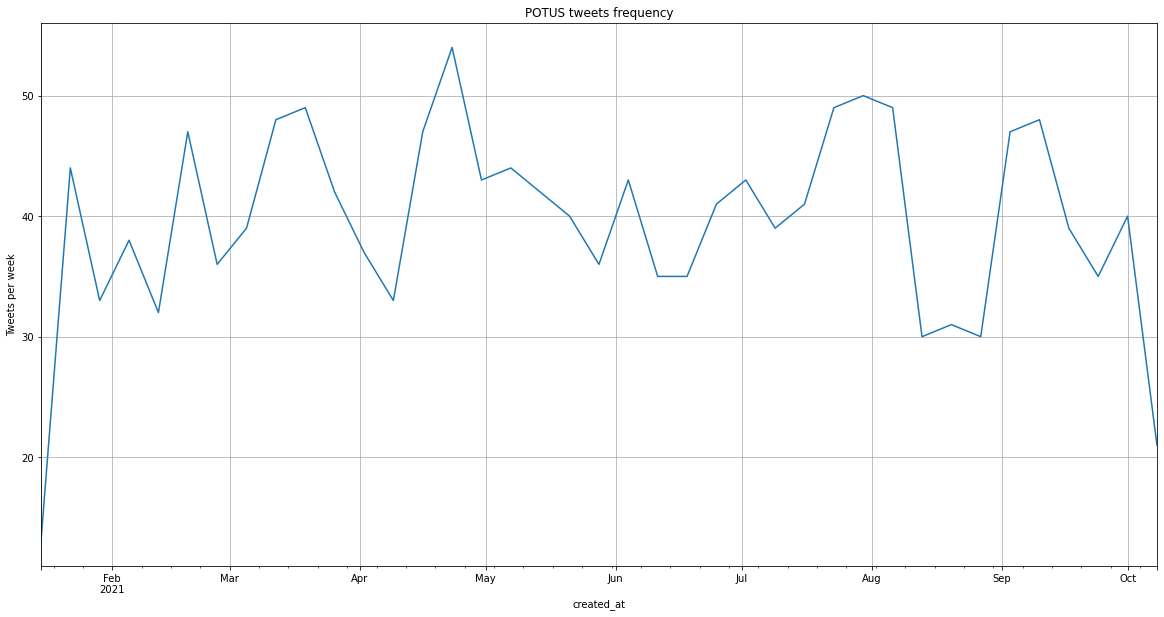

In [14]:
tweetsPerDay("POTUS")

In [25]:
translateTweets("ScottMorrisonMP")

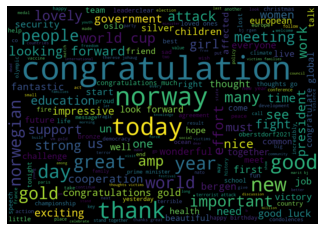

In [66]:
generateWordCloud("erna_solberg", False)

In [50]:
for leader in world_leaders:
    getTweetsFromUser(leader)

fetching before 1436075149615321091
370 downloaded so far
fetching before 1423454387347890185
563 downloaded so far
fetching before 1412797679785099269
745 downloaded so far
fetching before 1400824211803881476
932 downloaded so far
fetching before 1389308787304108035
1129 downloaded so far
fetching before 1377367570831921151
1312 downloaded so far
fetching before 1366879571124121605
1502 downloaded so far
fetching before 1354185009343590401
1543 downloaded so far
fetching before 1349918127413407746
1543 downloaded so far
fetching before 1351957101086728201
131 downloaded so far
fetching before 1276961974065266688
191 downloaded so far
fetching before 1129837082615177220
256 downloaded so far
fetching before 1015146773717880831
324 downloaded so far
fetching before 906774480655192063
371 downloaded so far
fetching before 838389962496217087
439 downloaded so far
fetching before 761927871963107327
506 downloaded so far
fetching before 715119409296252927
565 downloaded so far
fetching befo

In [54]:
for leader in world_leaders:
    cleanBlankLines(f'raw_tweets/v3_{leader}_tweets.csv')

In [14]:
translateTweets("JeanCASTEX")

KeyboardInterrupt: 

In [8]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to roberta-large-mnli (https://huggingface.co/roberta-large-mnli)
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at roberta-large-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [9]:
df = pd.read_csv('processing/cleaned_dataset.csv')
df.head(5)

,english
0,educating girls doesn_t just improve lives it ...
1,it_takes courage to speak_out about mental_hea...
2,desperately sad to hear the news about james b...
3,fantastic_news that the uae has_become the fir...
4,the uk is honoured to host these_games in the ...


In [10]:
labels = ['positive', 'negative', 'neutral']
hypo = "The sentiment of this tweet is {}."
def get_sentiment_zeroshot(text):
    try:
        res = classifier(text, labels, hypothesis_template = hypo)
        if(res['labels'][0] == 'positive' and res['scores'][0] > 0.5):
            return "POSITIVE"
        elif(res['labels'][0] == 'negative' and res['scores'][0] > 0.5):
            return "NEGATIVE"
        else:
            return "NEUTRAL"
    except:
        return "UNABLE_TO_PROCESS"

In [11]:
tqdm.pandas()
df['sentiment'] = df['english'].progress_apply(lambda x: get_sentiment_zeroshot(x))
df.head(20)

100%|██████████| 17127/17127 [4:50:54<00:00,  1.02s/it]  


,english,sentiment
0,educating girls doesn_t just improve lives it ...,POSITIVE
1,it_takes courage to speak_out about mental_hea...,POSITIVE
2,desperately sad to hear the news about james b...,NEGATIVE
3,fantastic_news that the uae has_become the fir...,POSITIVE
4,the uk is honoured to host these_games in the ...,POSITIVE
5,delighted to welcome admiral sir tony radakin ...,POSITIVE
6,we are a step_closer to eradicating malaria wh...,POSITIVE
7,by uk electricity will_be carbon_free using so...,POSITIVE
8,what a fantastic conference we’re_getting on w...,POSITIVE
9,join_me live at cpc as we buildbackbetter,POSITIVE


In [12]:
df.to_csv('processing/labeled.csv', header = True)

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analize = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    try:
        sentiment = analize.polarity_scores(text)
    except:
        return "UNABLE_TO_PROCESS"
    comp = sentiment['compound']
    if comp >= 0.05:
        return "POSITIVE"
    elif comp > -0.05 and comp < 0.05:
        return "NEUTRAL"
    else:
        return "NEGATIVE"

In [14]:
df.head(5)

,english,sentiment
0,educating girls doesn_t just improve lives it ...,POSITIVE
1,it_takes courage to speak_out about mental_hea...,POSITIVE
2,desperately sad to hear the news about james b...,NEGATIVE
3,fantastic_news that the uae has_become the fir...,POSITIVE
4,the uk is honoured to host these_games in the ...,POSITIVE


In [15]:
df['vader_sentiment'] = df['english'].progress_apply(lambda x: get_vader_sentiment(x))
df.head(20)

100%|██████████| 17127/17127 [00:02<00:00, 5756.52it/s]


,english,sentiment,vader_sentiment
0,educating girls doesn_t just improve lives it ...,POSITIVE,POSITIVE
1,it_takes courage to speak_out about mental_hea...,POSITIVE,POSITIVE
2,desperately sad to hear the news about james b...,NEGATIVE,POSITIVE
3,fantastic_news that the uae has_become the fir...,POSITIVE,POSITIVE
4,the uk is honoured to host these_games in the ...,POSITIVE,POSITIVE
5,delighted to welcome admiral sir tony radakin ...,POSITIVE,POSITIVE
6,we are a step_closer to eradicating malaria wh...,POSITIVE,POSITIVE
7,by uk electricity will_be carbon_free using so...,POSITIVE,POSITIVE
8,what a fantastic conference we’re_getting on w...,POSITIVE,POSITIVE
9,join_me live at cpc as we buildbackbetter,POSITIVE,NEUTRAL


In [16]:
df.to_csv('processing/labeled.csv', header = True)

In [29]:
print(analize.polarity_scores("very saddened"))

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5709}


In [17]:
df[(df.sentiment == df.vader_sentiment)].shape

(10660, 3)

In [18]:
from textblob import TextBlob

def get_blob_sentiment(text):
    try:
        pol = TextBlob(text).sentiment.polarity
    except:
        return "UNABLE_TO_PROCESS"
    if pol > 0:
        return "POSITIVE"
    elif pol == 0:
        return "NEUTRAL"
    else:
        return "NEGATIVE"

In [19]:
df['blob_sentiment'] = df['english'].progress_apply(lambda x: get_blob_sentiment(x))

100%|██████████| 17127/17127 [00:04<00:00, 3585.93it/s]


In [23]:
df.head(50)
df.shape[0]

17127

In [21]:
df.to_csv('processing/labeled.csv', header = True)

In [87]:
def get_count_by_profile(profiles):
    res = dict.fromkeys(profiles, 0)
    for profile in profiles:
        count = 0
        profdf = pd.read_csv(f'translated_tweets/translated_{profile}.csv')
        count = profdf.shape[0]
        res[profile] = count
    return res

{'POTUS': 1543, 'erna_solberg': 933, 'BorisJohnson': 2233, 'JeanCASTEX': 1014, 'JustinTrudeau': 1858, 'naftalibennett': 2100, 'kishida230': 569, 'narendramodi': 3050, 'sanchezcastejon': 1649, 'ScottMorrisonMP': 2230}


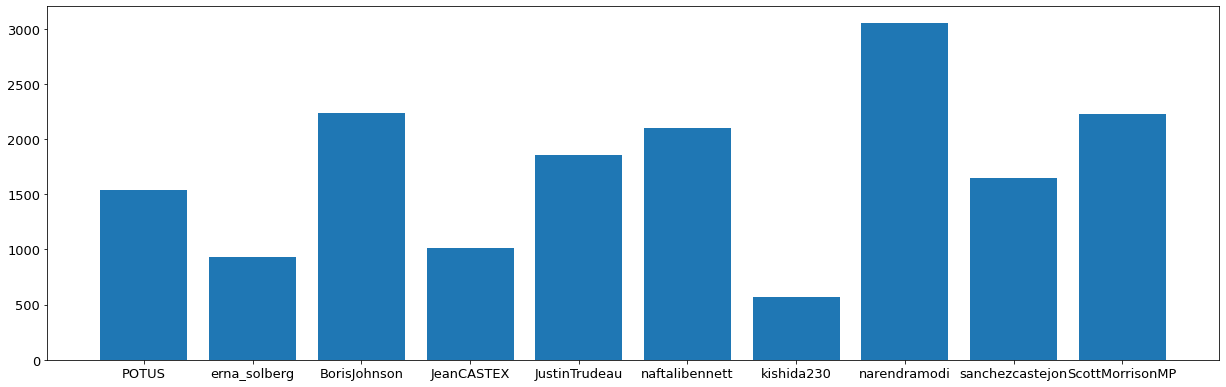

In [100]:
toplot = get_count_by_profile(world_leaders)
print(toplot)
plt.bar(range(len(toplot)), list(toplot.values()), align='center')
plt.xticks(range(len(toplot)), list(toplot.keys()))
plt.rcParams["figure.figsize"] = (21,6.5)
plt.rcParams["font.size"] = 13
plt.savefig('images/tweetsByProfile.png', bbox_inches='tight')
plt.show()

In [36]:
import os
import glob
def concat_withkeys():
    path = r'exp'
    all_files = glob.glob(os.path.join(path, "*.csv"))
    names = [os.path.basename(x) for x in all_files]
    df = pd.DataFrame()

    for file_, name in zip(all_files, names):
        file_df = pd.read_csv(file_, index_col=0)
        file_df['user'] = name.split('.')[0]
        df = df.append(file_df)
    
    df.head(10)
    return df

In [170]:
expdf = concat_withkeys()

In [85]:
expdf['created_at'] = pd.to_datetime(expdf['created_at']) - pd.to_timedelta(7, unit='d')
expdf = expdf.groupby(['user', pd.Grouper(key='created_at', freq='W-MON')])['english'].count().reset_index().sort_values('created_at')
expdf.head(100)

,user,created_at,english
582,erna_solberg,2013-09-09 00:00:00+00:00,2
583,erna_solberg,2013-10-14 00:00:00+00:00,3
584,erna_solberg,2013-10-21 00:00:00+00:00,1
585,erna_solberg,2013-10-28 00:00:00+00:00,4
586,erna_solberg,2013-11-04 00:00:00+00:00,4
...,...,...,...
273,ScottMorrisonMP,2015-08-31 00:00:00+00:00,10
673,erna_solberg,2015-08-31 00:00:00+00:00,4
674,erna_solberg,2015-09-07 00:00:00+00:00,2
274,ScottMorrisonMP,2015-09-07 00:00:00+00:00,26


<AxesSubplot:xlabel='created_at'>

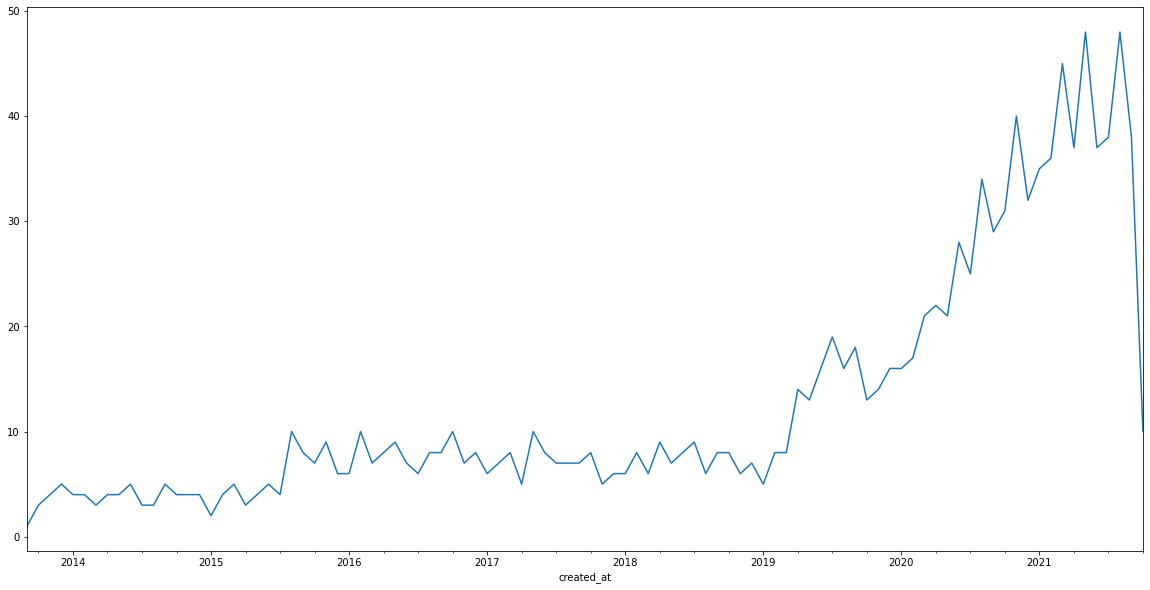

In [86]:
expdf = expdf.groupby(pd.Grouper(key='created_at', freq='1M', convention='start')).size()
expdf.plot(x = 'created_at', y = 'english', figsize=(20, 10), kind = 'line')

In [171]:
expdf['created_at'] = pd.to_datetime(expdf['created_at'])
expdf = expdf.groupby([pd.Grouper(key='created_at', freq='W-MON')])['english'].count().reset_index().sort_values('created_at')
print(expdf.created_at.max())
print(expdf.created_at.min())

2021-10-11 00:00:00+00:00
2013-09-16 00:00:00+00:00


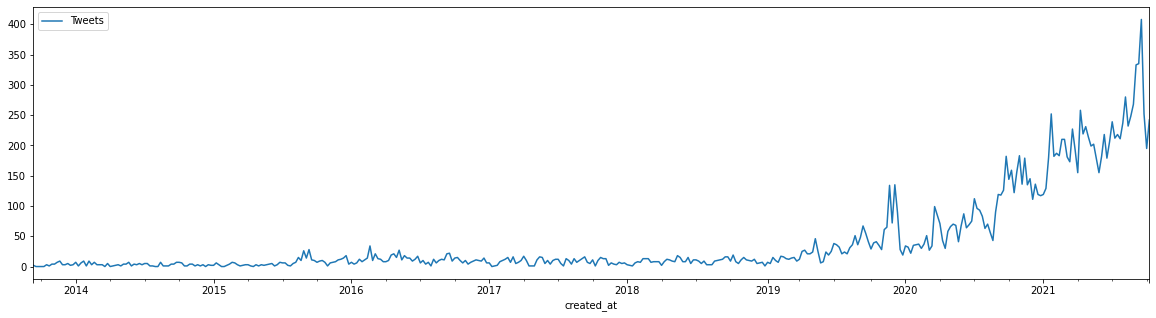

In [172]:
figure = expdf.plot(x = 'created_at', y = 'english', figsize=(20, 5), label = 'Tweets').get_figure()
figure.savefig('images/tweetsByWeek.png', bbox_inches='tight')

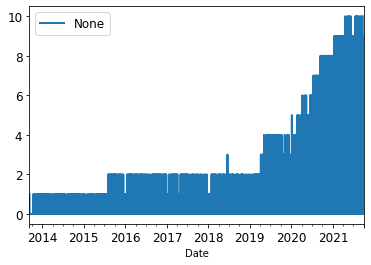

In [6]:
res_df = pd.read_csv("processing/labeled.csv")
res_df.head(50)

,Unnamed: 0,english,sentiment,vader_sentiment,blob_sentiment
0,0,educating girls doesn_t just improve lives it ...,POSITIVE,POSITIVE,NEUTRAL
1,1,it_takes courage to speak_out about mental_hea...,POSITIVE,POSITIVE,NEUTRAL
2,2,desperately sad to hear the news about james b...,NEGATIVE,POSITIVE,POSITIVE
3,3,fantastic_news that the uae has_become the fir...,POSITIVE,POSITIVE,POSITIVE
4,4,the uk is honoured to host these_games in the ...,POSITIVE,POSITIVE,POSITIVE
5,5,delighted to welcome admiral sir tony radakin ...,POSITIVE,POSITIVE,POSITIVE
6,6,we are a step_closer to eradicating malaria wh...,POSITIVE,POSITIVE,POSITIVE
7,7,by uk electricity will_be carbon_free using so...,POSITIVE,POSITIVE,POSITIVE
8,8,what a fantastic conference we’re_getting on w...,POSITIVE,POSITIVE,POSITIVE
9,9,join_me live at cpc as we buildbackbetter,POSITIVE,NEUTRAL,POSITIVE


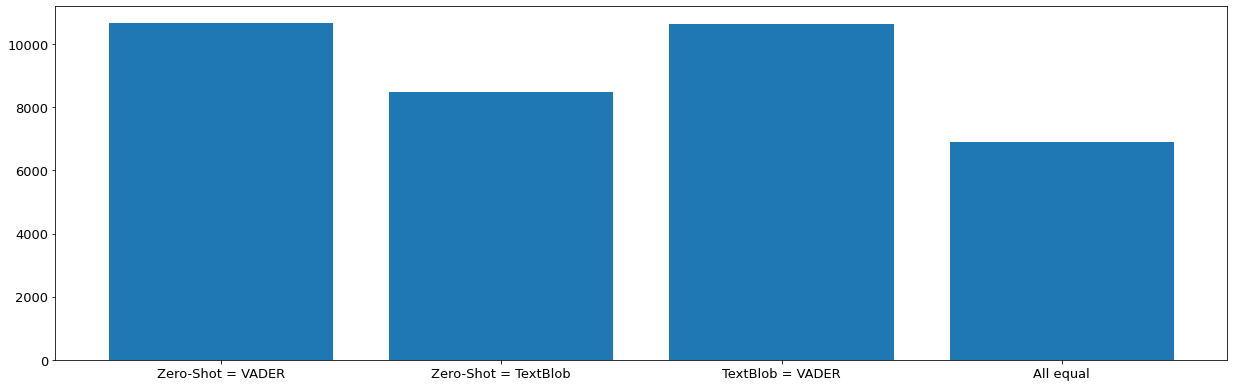

In [29]:
keys = ['zero_vader', 'zero_blob', 'blob_vader', 'all']
dkt = dict.fromkeys(keys, 0)
dkt['zero_vader'] = res_df[(res_df.sentiment == res_df.vader_sentiment)].shape[0]
dkt['zero_blob'] = res_df[(res_df.sentiment == res_df.blob_sentiment)].shape[0]
dkt['blob_vader'] = res_df[(res_df.blob_sentiment == res_df.vader_sentiment)].shape[0]
dkt['all'] = res_df[((res_df.blob_sentiment == res_df.vader_sentiment) & (res_df.blob_sentiment == res_df.sentiment))].shape[0]
plt.bar(range(len(dkt)), list(dkt.values()), align='center')
plt.xticks(range(len(dkt)), ['Zero-Shot = VADER', 'Zero-Shot = TextBlob', 'TextBlob = VADER', 'All equal'])
plt.rcParams["figure.figsize"] = (21,6.5)
plt.rcParams["font.size"] = 13
plt.savefig('images/analizers.png', bbox_inches='tight')
plt.show()

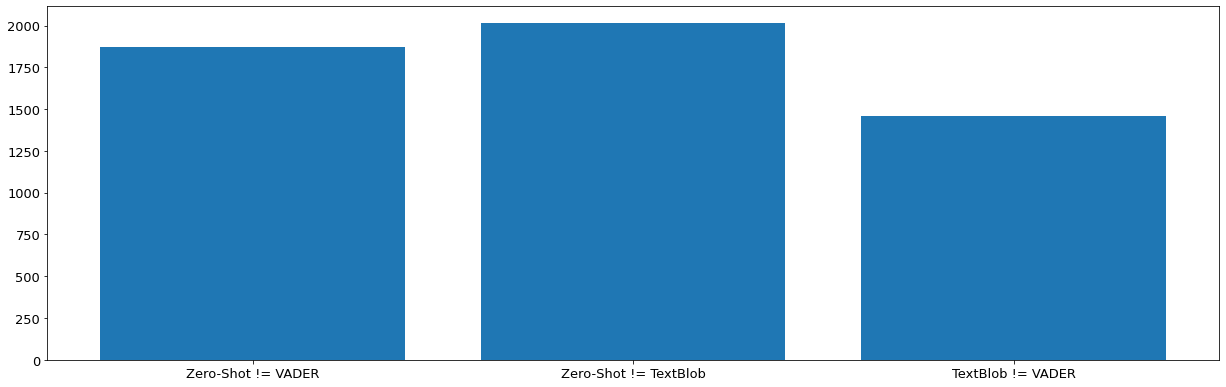

In [32]:
keys2 = ['zero_vader', 'zero_blob', 'blob_vader']
dkt2 = dict.fromkeys(keys2, 0)
dkt2['zero_vader'] = res_df[(((res_df.sentiment == 'POSITIVE') & (res_df.vader_sentiment == 'NEGATIVE')) | ((res_df.sentiment == 'NEGATIVE') & (res_df.vader_sentiment == 'POSITIVE')))].shape[0]
dkt2['zero_blob'] = res_df[(((res_df.sentiment == 'POSITIVE') & (res_df.blob_sentiment == 'NEGATIVE')) | ((res_df.sentiment == 'NEGATIVE') & (res_df.blob_sentiment == 'POSITIVE')))].shape[0]
dkt2['blob_vader'] = res_df[(((res_df.vader_sentiment == 'POSITIVE') & (res_df.blob_sentiment == 'NEGATIVE')) | ((res_df.vader_sentiment == 'NEGATIVE') & (res_df.blob_sentiment == 'POSITIVE')))].shape[0]
plt.bar(range(len(dkt2)), list(dkt2.values()), align='center')
plt.xticks(range(len(dkt2)), ['Zero-Shot != VADER', 'Zero-Shot != TextBlob', 'TextBlob != VADER'])
plt.rcParams["figure.figsize"] = (21,6.5)
plt.rcParams["font.size"] = 13
plt.savefig('images/analizersellentmond.png', bbox_inches='tight')
plt.show()